# Preprocessing big in vivo data!

We have some big files here.  Lots and lots of cells.

# Loading packages

In [1]:
import pandas as pd  # Pandas for data analysis.
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
from IPython.display import display # Pretty display of data frames.

from sklearn import base
from sklearn.feature_selection import chi2, f_classif

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
file_prefix = 'write/anndata'
file_suffix = '.loom'  

In [3]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

# Loading data

## Getting gene data

Gene data was downloaded [GRCh7 at the biomart](https://grch37.ensembl.org/info/data/biomart/index.html), and we work at the level of distinct Ensembl IDs.  Transcript length (used for TPM normalization) is obtained by averaging all entries with a given Ensembl ID.

In [4]:
def get_genes(filename, verbose=True):
    gene_raw = pd.read_csv(filename, sep='\t', index_col=0, header=0, low_memory=False)
    gene_raw.columns = ['transcript_length', 'gene_name', 'GC_content','transcript stable ID', 'TSS']
    if verbose:
        print('{} genes found in {}.'.format(len(gene_raw), filename))
    
    gene_lengths = gene_raw['transcript_length'].groupby(gene_raw.index).mean()
    gene_GCs = gene_raw['GC_content'].groupby(gene_raw.index).mean()
    gene_df = pd.DataFrame(gene_lengths, index=gene_lengths.index)
    gene_df['GC_content'] = gene_GCs
    gene_df['gene_name'] = gene_raw['gene_name'].groupby(gene_raw.index).first()
    if verbose:
        print('{} distinct Ensembl gene IDs found.'.format(len(gene_df)))
        display(gene_df.head())
    return gene_df

In [5]:
gene_df = get_genes('GRCh37_Biomart.txt')

215404 genes found in GRCh37_Biomart.txt.
63677 distinct Ensembl gene IDs found.


,transcript_length,GC_content,gene_name
Gene stable ID,,,
ENSG00000000003,1350.333333,40.87,TSPAN6
ENSG00000000005,940.500000,40.80,TNMD
ENSG00000000419,974.714286,39.85,DPM1
ENSG00000000457,3274.400000,40.14,SCYL3
ENSG00000000460,2197.200000,39.22,C1orf112


## Getting cell metadata

This data contains cells from four different sources.  Metadata is stored in four files accordingly.

In [6]:
datasets = ['A1_6','A1_30','JH','YFV2003']

In [7]:
meta_df = {}

time_verbose = False

for ds in datasets:
    filename = ds+'_MasterSheet_CJ_01_06_2021.csv'
    meta_df[ds] = pd.read_csv(filename, sep=',')
    meta_df[ds].index = meta_df[ds]['Sample_id']
    meta_df[ds].drop('Unnamed: 0', axis=1, inplace=True)
    print('                  Displaying metadata for {}'.format(ds))
    hrule()
    display(meta_df[ds].head())
    print(meta_df[ds]['Donor'].value_counts())
    hrule('-')
    print(meta_df[ds]['Condition'].value_counts())
    hrule('-')
    print(meta_df[ds]['Cell Number'].value_counts())
    hrule('-')
    print(meta_df[ds]['Timepoint'].value_counts())
    hrule('-')
    clonepops = meta_df[ds]['clone_id'].value_counts()
    print('{} Clones found'.format(len(clonepops)))
    print('{} Clones with >10 cells found'.format(len(clonepops[clonepops > 10])))
    print('{} Clones with >30 cells found'.format(len(clonepops[clonepops > 30])))
    if time_verbose:
        bigclones = clonepops[:10].index
        hrule('~')
        for clone in bigclones[:10]:
            print('Clone {}'.format(clone))
            meta_clone = meta_df[ds][meta_df[ds].clone_id == clone]
            timepops = meta_clone.Timepoint.value_counts()
            timestring = ''
            for timepoint in timepops.sort_values().index:
                timestring += '{} cells at day {}. \n'.format(timepops[timepoint], timepoint)
            print(timestring)
    hrule()

                  Displaying metadata for A1_6


,Donor,Condition,Timepoint,HLA Type,Clone_Number_In-Vitro,Cell Number,Sample_id,jeff_id,clone_id,TRA,...,nSeqCDR3_B,allVHitsWithScoreB,allDHitsWithScoreB,allJHitsWithScoreB,TRD,cloneCount_D,nSeqCDR3_D,TRG,cloneCount_G,nSeqCDR3_G
Sample_id,,,,,,,,,,,,,,,,,,,,,
P20407_A6_D180_p3_G10,A1_06,InVivo,180,B7,NaN,1,P20407_A6_D180_p3_G10,NaN,0.0,NaN,...,TGTGCCAGCAGTGAAGGGGGGACAGCGTATGGCTACACCTTC,TRBV2*00(658.7),TRBD1*00(35),TRBJ1-2*00(181.1),NaN,NaN,NaN,NaN,NaN,NaN
P20407_A6_D180_p1_C17,A1_06,InVivo,180,B7,NaN,1,P20407_A6_D180_p1_C17,NaN,1.0,CVGGNEKLTF,...,TGTGCCAGCAGTCCAGACACTAGCGGGGTCTATGAGCAGTTCTTC,TRBV6-5*00(645.9),TRBD2*00(45),TRBJ2-1*00(167.6),CVGGNEKLTF,110.0,TGTGTGGGGGGAAATGAGAAATTAACCTTT,CALWEVQLYYKKLF,73.0,TGTGCCTTGTGGGAGGTGCAACTTTATTATAAGAAACTCTTT
P20407_A6_D14_p3_H9,A1_06,InVivo,14,B7,NaN,1,P20407_A6_D14_p3_H9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P20407_A6_D180_p1_I19,A1_06,InVivo,180,B7,NaN,1,P20407_A6_D180_p1_I19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P20407_A6_D180_p1_N6,A1_06,InVivo,180,B7,NaN,1,P20407_A6_D180_p1_N6,NaN,2.0,CAGGDMRF,...,TGTGCCAGCAGCTGCTCCGACCCGATCGACACCGGGGAGCTGTTTTTT,TRBV6-6*00(639.4),NaN,TRBJ2-2*00(180.4),CAGGDMRF,30.0,TGTGCAGGGGGAGACATGCGCTTT,CAAWAARDKKLF,51.0,TGTGCTGCGTGGGCGGCTCGTGATAAGAAACTCTTT


A1_06    4224
Name: Donor, dtype: int64
--------------------------------------------------------------------------------
InVivo    4224
Name: Condition, dtype: int64
--------------------------------------------------------------------------------
1    4224
Name: Cell Number, dtype: int64
--------------------------------------------------------------------------------
14     2304
180    1920
Name: Timepoint, dtype: int64
--------------------------------------------------------------------------------
1124 Clones found
59 Clones with >10 cells found
12 Clones with >30 cells found
                  Displaying metadata for A1_30


,Donor,Timepoint,Condition,HLA Type,Clone_Number_In-Vitro,Cell Number,Sample_id,jeff_id,clone_id,TRA,...,nSeqCDR3_B,allVHitsWithScoreB,allDHitsWithScoreB,allJHitsWithScoreB,TRD,cloneCount_D,nSeqCDR3_D,TRG,cloneCount_G,nSeqCDR3_G
Sample_id,,,,,,,,,,,,,,,,,,,,,
P20407_A30_D180_p2_H19,A1_30,180,InVivo,B7,NaN,1,P20407_A30_D180_p2_H19,NaN,0.0,CAFGSDSWGKLQF,...,TGTGCCAGCAGCGGGGAGGGACTCTACAATGAGCAGTTCTTC,TRBV7-6*00(506.7),TRBD2*00(35),TRBJ2-1*00(208.1),CAFGSDSWGKLQF,100.0,TGTGCCTTTGGCTCTGACAGCTGGGGGAAATTGCAGTTT,NaN,NaN,NaN
P20407_A30_D180_p2_B17,A1_30,180,InVivo,B7,NaN,1,P20407_A30_D180_p2_B17,NaN,1.0,CAVKDDKIIF,...,TGTGCCACCGGACTCGGACAGGCCTACGAGCAGTACTTC,TRBV15*00(477.9),TRBD1*00(35),TRBJ2-7*00(183.1),CAVKDDKIIF,51.0,TGTGCCGTGAAGGATGACAAGATCATCTTT,NaN,NaN,NaN
P20407_A30_D14_p1_N20,A1_30,14,InVivo,B7,NaN,1,P20407_A30_D14_p1_N20,NaN,2.0,CAVTGGKLIF,...,TGTGCCAGCAGCGTGAGCGGTAGCTCCTACGAGCAGTACTTC,TRBV9*00(403.4),TRBD2*00(25),TRBJ2-7*00(232.5),CAVTGGKLIF,165.0,TGTGCCGTGACGGGAGGAAAGCTTATCTTC,NaN,NaN,NaN
P20407_A30_D180_p5_L7,A1_30,180,InVivo,B7,NaN,1,P20407_A30_D180_p5_L7,NaN,3.0,CAVSDYKLSF,...,TGTGCCAGCAGTGCCGGGACAGCATATGGCTACACCTTC,TRBV27*00(584.5),TRBD1*00(45),TRBJ1-2*00(172.6),CAVSDYKLSF,177.0,TGTGCCGTGAGTGACTACAAGCTCAGCTTT,NaN,NaN,NaN
P20407_A30_D14_p3_H15,A1_30,14,InVivo,B7,NaN,1,P20407_A30_D14_p3_H15,NaN,4.0,CAGPPDTGNQFYF,...,TGTGCCACCAGCAGTGCCGTTGGATACGAGCAGTACTTC,TRBV15*00(314.9),NaN,TRBJ2-7*00(196.8),CAGPPDTGNQFYF,131.0,TGTGCTGGGCCCCCCGACACCGGTAACCAGTTCTATTTT,NaN,NaN,NaN


A1_30    4224
Name: Donor, dtype: int64
--------------------------------------------------------------------------------
InVivo    4224
Name: Condition, dtype: int64
--------------------------------------------------------------------------------
1    4224
Name: Cell Number, dtype: int64
--------------------------------------------------------------------------------
14     2304
180    1920
Name: Timepoint, dtype: int64
--------------------------------------------------------------------------------
1616 Clones found
44 Clones with >10 cells found
8 Clones with >30 cells found
                  Displaying metadata for JH


,Donor,Condition,Timepoint,Cell Type,HLA Type,Clone_Number_In-Vitro,Cell Number,Sample_id,jeff_id,clone_id,...,nSeqCDR3_B,allVHitsWithScoreB,allDHitsWithScoreB,allJHitsWithScoreB,TRD,cloneCount_D,nSeqCDR3_D,TRG,cloneCount_G,nSeqCDR3_G
Sample_id,,,,,,,,,,,,,,,,,,,,,
JHDex_58,YFV2003,InVivo,2000,CD8,A2,NaN,1,JHDex_58,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JHDex_248,YFV2003,InVivo,2000,CD8,A2,NaN,1,JHDex_248,NaN,0.0,...,TGTGCCAGCAGCGTAGCTACGGAATCCTACGAGCAGTACTTC,TRBV9*00(585.5),NaN,TRBJ2-7*00(190.2),CAVMGQKVTF,22.0,TGTGCCGTGATGGGGCAGAAAGTTACCTTT,NaN,NaN,NaN
JHDex_846,YFV2003,InVivo,2000,CD8,A2,NaN,1,JHDex_846,NaN,1.0,...,TGCGCCAGCAGCCAAGCCGAAGCCTACGAGCAGTACTTC,TRBV4-3*00(608.2),NaN,TRBJ2-7*00(184.8),CAVTPHYGGATNKLIF,92.0,TGTGCTGTCACTCCCCATTATGGTGGTGCTACAAACAAGCTCATCTTT,NaN,NaN,NaN
JHDex_1149,YFV2003,InVivo,2000,CD8,A2,NaN,1,JHDex_1149,NaN,2.0,...,TGTGCCAGCGCCGGGACCGACAATTCACCCCTCCACTTT,TRBV9*00(531.1),"TRBD1*00(35),TRBD2*00(35)",TRBJ1-6*00(184.8),CAADGLTF,39.0,TGTGCCGCGGATGGCCTCACCTTT,NaN,NaN,NaN
P20407_JH_D15_p1_P10,YFV2003,InVivo,14,CD8,A2,NaN,1,P20407_JH_D15_p1_P10,NaN,3.0,...,TGTGCCAGCAGTGAATCACCGGGACAGGGGGCCTATGGCTACACCTTC,TRBV6-1*00(844.6),TRBD1*00(70),TRBJ1-2*00(191.2),CAVGGQNFVF,26.0,TGTGCCGTGGGGGGTCAGAATTTTGTCTTT,NaN,NaN,NaN


YFV2003    2661
Name: Donor, dtype: int64
--------------------------------------------------------------------------------
InVivo    2661
Name: Condition, dtype: int64
--------------------------------------------------------------------------------
1    2661
Name: Cell Number, dtype: int64
--------------------------------------------------------------------------------
2000    1509
14      1152
Name: Timepoint, dtype: int64
--------------------------------------------------------------------------------
586 Clones found
36 Clones with >10 cells found
5 Clones with >30 cells found
                  Displaying metadata for YFV2003


,Donor,Condition,Timepoint,experiment_type,HLA Type,Clone_Number_In-Vitro,Cell Number,Cell_Type,Sample_id,jeff_id,...,nSeqCDR3_B,allVHitsWithScoreB,allDHitsWithScoreB,allJHitsWithScoreB,TRD,cloneCount_D,nSeqCDR3_D,TRG,cloneCount_G,nSeqCDR3_G
Sample_id,,,,,,,,,,,,,,,,,,,,,
invivo2_7F_556_S172,YFV2003,InVivo,1401.0,smartseq3,A2,NaN,1,CD8,invivo2_7F_556_S172,NaN,...,TGTGCCACCAGCACAGGGACAGGGCCATACGAGCAGTACTTC,TRBV15*00(370.6),TRBD1*00(45),TRBJ2-7*00(199.6),CVVTPTDKLIF,167.0,TGTGTGGTGACCCCCACCGACAAGCTCATCTTT,NaN,NaN,NaN
P20407_YFV2003_D15_p4_C7,YFV2003,InVivo,15.0,smartseq3,A2,NaN,1,CD8,P20407_YFV2003_D15_p4_C7,NaN,...,TGTGCCAGCAGCGCCTCAGGGGATGCCTACGAGCAGTACTTC,TRBV9*00(528.2),TRBD1*00(30),TRBJ2-7*00(210.9),CAGGGGKLIF,27.0,TGTGCCGGTGGGGGAGGAAAGCTTATCTTC,NaN,NaN,NaN
invitro_P1P2_273_S273,YFV2003,InVitro,NaN,smartseq3,A2,NaN,1,CD8,invitro_P1P2_273_S273,NaN,...,TGTGCCACCAGCTCTGGAGGGGCTTACGAGCAGTACTTC,TRBV15*00(526.1),TRBD2*00(30),TRBJ2-7*00(182.1),CAVGGSRLTF,217.0,TGTGCCGTGGGTGGCTCTAGGTTGACCTTT,NaN,NaN,NaN
P20407_YFV2003_D15_p1_G14,YFV2003,InVivo,15.0,smartseq3,A2,NaN,1,CD8,P20407_YFV2003_D15_p1_G14,NaN,...,TGTGCCAGCAGTGACTCGAGTGGGAGTAACAATGAGCAGTTCTTC,TRBV6-4*00(600.8),TRBD2*00(25),TRBJ2-1*00(182),CAVINSNYQLIW,25.0,TGTGCTGTGATAAATAGCAACTATCAGTTAATCTGG,NaN,NaN,NaN
P20407_YFV2003_D15_p3_C13,YFV2003,InVivo,15.0,smartseq3,A2,NaN,1,CD8,P20407_YFV2003_D15_p3_C13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


YFV2003    5419
Name: Donor, dtype: int64
--------------------------------------------------------------------------------
InVivo     4602
InVitro     817
Name: Condition, dtype: int64
--------------------------------------------------------------------------------
1     5368
20      51
Name: Cell Number, dtype: int64
--------------------------------------------------------------------------------
15.0      3456
1401.0     762
Name: Timepoint, dtype: int64
--------------------------------------------------------------------------------
1869 Clones found
47 Clones with >10 cells found
9 Clones with >30 cells found


In [8]:
meta_cells = []
for ds in datasets:
    cells_batch = list(meta_df[ds].index)
    print('There are {} cells in {}'.format(len(cells_batch), ds))
    meta_cells += cells_batch
print('Total {} cells contained in metadata'.format(len(meta_cells)))

There are 4224 cells in A1_6
There are 4224 cells in A1_30
There are 2661 cells in JH
There are 5419 cells in YFV2003
Total 16528 cells contained in metadata


## Getting expression matrices

The expression matrices are huge here, contained in a 3GB csv file.  So we read this into pandas in chunks, and store the chunks sparsely when we can. 

In [9]:
def load_lane(filename, chunk_mem = 1e8, sparsify=True, test_run = False):
    df_head = pd.read_csv(filename, sep='\t', nrows=5, index_col = 0)
    usecols = [0] + list(range(2, len(df_head.columns)+1)) # Skip gene name.  Just use Ensembl ID.
    
    dtype_dict = {j:np.uint32 for j in usecols} # Unsigned 32-bit integers to be safe.  4 bytes per entry.
    dtype_dict[0] = str
    
    mem_needed = 4 * len(usecols) * len(gene_df)
    chunksize = chunk_mem // (4 * len(usecols))
    print('About {:,} bytes of memory needed for dataframe.'.format(mem_needed))
    print('Using {} chunks of {} genes, each needing {:,} bytes of memory.'.format(len(gene_df) // chunksize,
                                                                                   chunksize, 
                                                                                   4*len(usecols)*chunksize))
    df_list = []
    j = 0
    if test_run:
        chunksize = 100
    print('Starting to load expression matrix now.  Please be patient.')
    for chunk in pd.read_csv(filename, sep='\t', index_col = 0, usecols=usecols, 
                             dtype=dtype_dict, chunksize=chunksize):
        j += 1
        print('{} genes loaded.'.format(j * chunksize))
        df = chunk
        if sparsify:
            old_mem = df.memory_usage().sum()
            df = df.astype(pd.SparseDtype(np.uint32, fill_value=0))
            new_mem = df.memory_usage().sum()
            print('Chunk sparsified from {:,} to {:,} bytes'.format(old_mem, new_mem))
        df_list.append(df)
        if test_run:
            if j > 3:
                return df_list
    return df_list
    

The following was used when we just had data from one lane of the sequencer.

In [10]:
# filename = 'lane2-readcounts-exon.csv'
# lane2_list = load_lane(filename, test_run=False)
# Now we concatenate the dataframes.

# lane2_df = pd.concat(lane2_list)
#lane_mem = lane2_df.memory_usage().sum()
# print('{:,} bytes of memory used in lane.'.format(lane_mem))

Now we have data from all 3 lanes.  It's UMI data, and it will take a little while (5-10 minutes) to load.  The v2 extension refers to the version of the data shared on July 6th, 2021., correcting some minor issue.

In [11]:
filename = 'bigss3-umicounts-exon_v2.csv'
alllane_list = load_lane(filename, test_run=False)

About 3,168,058,104 bytes of memory needed for dataframe.
Using 31.0 chunks of 2009.0 genes, each needing 99,951,768.0 bytes of memory.
Starting to load expression matrix now.  Please be patient.
2009.0 genes loaded.
Chunk sparsified from 99,959,804 to 13,820,944 bytes
4018.0 genes loaded.
Chunk sparsified from 99,959,804 to 13,222,544 bytes
6027.0 genes loaded.
Chunk sparsified from 99,959,804 to 8,691,704 bytes
8036.0 genes loaded.
Chunk sparsified from 99,959,804 to 9,944,992 bytes
10045.0 genes loaded.
Chunk sparsified from 99,959,804 to 11,797,200 bytes
12054.0 genes loaded.
Chunk sparsified from 99,959,804 to 10,603,568 bytes
14063.0 genes loaded.
Chunk sparsified from 99,959,804 to 11,807,736 bytes
16072.0 genes loaded.
Chunk sparsified from 99,959,804 to 9,541,352 bytes
18081.0 genes loaded.
Chunk sparsified from 99,959,804 to 7,976,256 bytes
20090.0 genes loaded.
Chunk sparsified from 99,959,804 to 12,088,592 bytes
22099.0 genes loaded.
Chunk sparsified from 99,959,804 to 12,1

In [12]:
alllane_df = pd.concat(alllane_list)
lane_mem = alllane_df.memory_usage().sum()
print('{:,} bytes of memory used in lane.'.format(lane_mem))

301,976,688 bytes of memory used in lane.


In [13]:
alllane_df.head()

,A1_06_Day_14_plate_3:M3,A1_06_Day_14_plate_3:K3,A1_06_Day_14_plate_3:P3,A1_06_Day_14_plate_3:A3,A1_06_Day_14_plate_3:E3,A1_06_Day_14_plate_3:H3,A1_06_Day_14_plate_3:N3,A1_06_Day_14_plate_3:D3,A1_06_Day_14_plate_3:B3,A1_06_Day_14_plate_3:C3,...,A1_30_Day_180_plate_2:M5,A1_30_Day_14_plate_3:I5,A1_30_Day_14_plate_3:J5,A1_30_Day_14_plate_3:P5,A1_30_Day_180_plate_2:P5,A1_30_Day_14_plate_3:M5,A1_30_Day_180_plate_2:B5,A1_30_Day_180_plate_2:D5,A1_30_Day_180_plate_2:J5,A1_30_Day_14_plate_3:G5
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,0,2,3,2,0,0,0,5,0,0,...,2,2,0,2,1,5,1,0,0,0
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The cell names in the expression matrix are slightly different from those in the metadata.  Here's a function to convert them.

In [14]:
def metify(cell, prefix='P20407_'):
    rep_dict = {'A1_06':'A6', 'A1_30':'A30', 'plate_':'p', ':':'_', 'Day_':'D'}
    newcell = cell
    for key in rep_dict.keys():
        newcell = newcell.replace(key, rep_dict[key])
    newcell = prefix + newcell
    return newcell

In [15]:
cells = alllane_df.columns
cells_metted = [metify(cell) for cell in cells]
alllane_df.columns = cells_metted

In [16]:
cells = alllane_df.columns
good_cells = [cell for cell in cells if cell in meta_cells]
print('There are {} cells in the lane.  {} of these are in the metadata'.format(len(cells),
                                                                               len(good_cells)))

There are 12437 cells in the lane.  12437 of these are in the metadata


In [17]:
alllane_df

,P20407_A6_D14_p3_M3,P20407_A6_D14_p3_K3,P20407_A6_D14_p3_P3,P20407_A6_D14_p3_A3,P20407_A6_D14_p3_E3,P20407_A6_D14_p3_H3,P20407_A6_D14_p3_N3,P20407_A6_D14_p3_D3,P20407_A6_D14_p3_B3,P20407_A6_D14_p3_C3,...,P20407_A30_D180_p2_M5,P20407_A30_D14_p3_I5,P20407_A30_D14_p3_J5,P20407_A30_D14_p3_P5,P20407_A30_D180_p2_P5,P20407_A30_D14_p3_M5,P20407_A30_D180_p2_B5,P20407_A30_D180_p2_D5,P20407_A30_D180_p2_J5,P20407_A30_D14_p3_G5
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,0,2,3,2,0,0,0,5,0,0,...,2,2,0,2,1,5,1,0,0,0
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000224240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000227629,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Make new metadata

Here we extract the metadata for the cells in the expression matrix.  We keep only information about donor, timepoint, and clone ID.

We begin by correcting an error in the donor for the JH data set.

In [18]:
meta_df['JH'].Donor = 'JH'
meta_df['JH']

,Donor,Condition,Timepoint,Cell Type,HLA Type,Clone_Number_In-Vitro,Cell Number,Sample_id,jeff_id,clone_id,...,nSeqCDR3_B,allVHitsWithScoreB,allDHitsWithScoreB,allJHitsWithScoreB,TRD,cloneCount_D,nSeqCDR3_D,TRG,cloneCount_G,nSeqCDR3_G
Sample_id,,,,,,,,,,,,,,,,,,,,,
JHDex_58,JH,InVivo,2000,CD8,A2,NaN,1,JHDex_58,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JHDex_248,JH,InVivo,2000,CD8,A2,NaN,1,JHDex_248,NaN,0.0,...,TGTGCCAGCAGCGTAGCTACGGAATCCTACGAGCAGTACTTC,TRBV9*00(585.5),NaN,TRBJ2-7*00(190.2),CAVMGQKVTF,22.0,TGTGCCGTGATGGGGCAGAAAGTTACCTTT,NaN,NaN,NaN
JHDex_846,JH,InVivo,2000,CD8,A2,NaN,1,JHDex_846,NaN,1.0,...,TGCGCCAGCAGCCAAGCCGAAGCCTACGAGCAGTACTTC,TRBV4-3*00(608.2),NaN,TRBJ2-7*00(184.8),CAVTPHYGGATNKLIF,92.0,TGTGCTGTCACTCCCCATTATGGTGGTGCTACAAACAAGCTCATCTTT,NaN,NaN,NaN
JHDex_1149,JH,InVivo,2000,CD8,A2,NaN,1,JHDex_1149,NaN,2.0,...,TGTGCCAGCGCCGGGACCGACAATTCACCCCTCCACTTT,TRBV9*00(531.1),"TRBD1*00(35),TRBD2*00(35)",TRBJ1-6*00(184.8),CAADGLTF,39.0,TGTGCCGCGGATGGCCTCACCTTT,NaN,NaN,NaN
P20407_JH_D15_p1_P10,JH,InVivo,14,CD8,A2,NaN,1,P20407_JH_D15_p1_P10,NaN,3.0,...,TGTGCCAGCAGTGAATCACCGGGACAGGGGGCCTATGGCTACACCTTC,TRBV6-1*00(844.6),TRBD1*00(70),TRBJ1-2*00(191.2),CAVGGQNFVF,26.0,TGTGCCGTGGGGGGTCAGAATTTTGTCTTT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JHDex_23,JH,InVivo,2000,CD8,A2,NaN,1,JHDex_23,NaN,546.0,...,TGTGCCAGCTCCCCAGGGAGTGGTAACTATGGCTACACCTTC,"TRBV12-3*00(518.7),TRBV12-4*00(518.7)","TRBD1*00(25),TRBD2*00(25)",TRBJ1-2*00(200.8),CAVDGFQKLVF,42.0,TGTGCCGTGGACGGCTTTCAGAAACTTGTATTT,NaN,NaN,NaN
P20407_JH_D15_p1_K24,JH,InVivo,14,CD8,A2,NaN,1,P20407_JH_D15_p1_K24,NaN,156.0,...,TGTGCCATCAGTGAGGGAGGGGACGGCGCCTACGAGCAGTACTTC,TRBV10-3*00(570.1),TRBD2*00(30),TRBJ2-7*00(184.5),CGASNYKLTF,136.0,TGTGGAGCTAGCAACTATAAACTGACATTT,NaN,NaN,NaN
P20407_JH_D15_p3_O23,JH,InVivo,14,CD8,A2,NaN,1,P20407_JH_D15_p3_O23,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
meta_list = []
prefixes = 'ABCDEFG'
for j,ds in enumerate(datasets):
    meta_temp = meta_df[ds].copy()
    cell_list = [cell for cell in cells if cell in meta_temp.index]
    meta_temp = meta_temp.loc[cell_list]
    meta_temp = meta_temp[['Donor','Timepoint','clone_id']]
    clone_pref = prefixes[j]
    meta_temp['clone_id'] = meta_temp['clone_id'].fillna(0) # Replace NaN by 0.
    meta_temp['clone_id'] = meta_temp['clone_id'].clip(0) # Replace -1 by 0.
    meta_temp['clone_id'] = clone_pref + meta_temp['clone_id'].astype(np.uint16).astype(str)
    meta_temp = meta_temp.astype({'Donor':str, 'Timepoint':np.uint16, 'clone_id':str})
    meta_list.append(meta_temp)

In [20]:
meta_all = pd.concat(meta_list)
meta_all['DonorDay'] = meta_all.Donor + '_D' + meta_all.Timepoint.astype(str)
meta_all

,Donor,Timepoint,clone_id,DonorDay
Sample_id,,,,
P20407_A6_D14_p3_M3,A1_06,14,A116,A1_06_D14
P20407_A6_D14_p3_K3,A1_06,14,A831,A1_06_D14
P20407_A6_D14_p3_P3,A1_06,14,A915,A1_06_D14
P20407_A6_D14_p3_A3,A1_06,14,A61,A1_06_D14
P20407_A6_D14_p3_E3,A1_06,14,A1029,A1_06_D14
...,...,...,...,...
P20407_YFV2003_D15_p6_J13,YFV2003,15,D0,YFV2003_D15
P20407_YFV2003_D15_p6_N13,YFV2003,15,D488,YFV2003_D15
P20407_YFV2003_D15_p6_B13,YFV2003,15,D1131,YFV2003_D15


In [21]:
meta_all.DonorDay.value_counts()

YFV2003_D15    3059
A1_06_D14      2286
A1_30_D14      2235
A1_06_D180     1913
A1_30_D180     1890
JH_D14         1054
Name: DonorDay, dtype: int64

## Moving into Scanpy

We move the expression matrices, with information about genes and cells, into Scanpy's AnnData objects.

In [67]:
def moveto_scanpy(counts, cell_meta, gene_meta, plain_name = True):
    adata = sc.AnnData(counts.T)
    for gene_property in gene_meta.columns:
        adata.var[gene_property] = gene_meta[gene_property]
    for cell_property in cell_meta.columns:
        adata.obs[cell_property] = cell_meta[cell_property]
    if plain_name:
        adata.var.index = adata.var['gene_name'] # Reindex by gene name
        adata.var_names_make_unique() # Use common gene names, but uniquify them.
    
    return adata

In [68]:
donordays = list(meta_all.DonorDay.unique())
print(donordays)

['A1_06_D14', 'A1_06_D180', 'A1_30_D14', 'A1_30_D180', 'JH_D14', 'YFV2003_D15']


In [69]:
adata = {}

for dd in donordays:
    meta = meta_all[meta_all.DonorDay == dd]
    counts = alllane_df[meta.index]
    adata[dd] = moveto_scanpy(counts, meta, gene_df)
    print('Donor_day {} migrated into ScanPy Anndata object.'.format(dd))

/opt/anaconda3/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD113-1', 'SNORD113-2']
  warnings.warn(


Donor_day A1_06_D14 migrated into ScanPy Anndata object.
Donor_day A1_06_D180 migrated into ScanPy Anndata object.
Donor_day A1_30_D14 migrated into ScanPy Anndata object.
Donor_day A1_30_D180 migrated into ScanPy Anndata object.
Donor_day JH_D14 migrated into ScanPy Anndata object.
Donor_day YFV2003_D15 migrated into ScanPy Anndata object.


In [70]:
adata['A1_06_D14']

AnnData object with n_obs × n_vars = 2286 × 63677
    obs: 'Donor', 'Timepoint', 'clone_id', 'DonorDay'
    var: 'transcript_length', 'GC_content', 'gene_name'

# Normalization and filtering

We first filter out genes which are never expressed above a count of 1, and those which are expressed in less than 5% of cells.

In [71]:
for dd in donordays:
    genes_before = adata[dd].n_vars
    sc.pp.filter_genes(adata[dd], min_counts=1) # At least 1 count.
    genes_after = adata[dd].n_vars
    print('Dataset {} has {} genes before and {} after filtering never-expressed.'.format(dd,genes_before,genes_after))
    sc.pp.filter_genes(adata[dd], min_cells=0.05*adata[dd].n_obs) # At least 5% of cells.
    genes_after = adata[dd].n_vars
    print('Dataset {} has {} genes before and {} after filtering based on 5% of cell cutoff.'.format(dd,genes_before,genes_after))
    hrule()

Dataset A1_06_D14 has 63677 genes before and 31182 after filtering never-expressed.
Dataset A1_06_D14 has 63677 genes before and 11173 after filtering based on 5% of cell cutoff.
Dataset A1_06_D180 has 63677 genes before and 28401 after filtering never-expressed.
Dataset A1_06_D180 has 63677 genes before and 8532 after filtering based on 5% of cell cutoff.
Dataset A1_30_D14 has 63677 genes before and 30207 after filtering never-expressed.
Dataset A1_30_D14 has 63677 genes before and 10532 after filtering based on 5% of cell cutoff.
Dataset A1_30_D180 has 63677 genes before and 28132 after filtering never-expressed.
Dataset A1_30_D180 has 63677 genes before and 8711 after filtering based on 5% of cell cutoff.
Dataset JH_D14 has 63677 genes before and 27841 after filtering never-expressed.
Dataset JH_D14 has 63677 genes before and 10274 after filtering based on 5% of cell cutoff.
Dataset YFV2003_D15 has 63677 genes before and 33179 after filtering never-expressed.
Dataset YFV2003_D15 has

Now we add annotations for highly variable genes.

In [72]:
for dd in donordays:
    print('Identifying highly variable genes in {}'.format(dd))
    sc.pp.highly_variable_genes(adata[dd], n_top_genes=7500, flavor='seurat_v3')

Identifying highly variable genes in A1_06_D14


/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


Identifying highly variable genes in A1_06_D180
Identifying highly variable genes in A1_30_D14
Identifying highly variable genes in A1_30_D180
Identifying highly variable genes in JH_D14
Identifying highly variable genes in YFV2003_D15


In [73]:
for dd in donordays:
    sc.pp.log1p(adata[dd]) #pseudo-log normalize.

In [74]:
for dd in donordays:
    print('Summary of AnnData object for {} (shape = #samples x #genes)'.format(dd))
    print(adata[dd])
    hrule()

Summary of AnnData object for A1_06_D14 (shape = #samples x #genes)
AnnData object with n_obs × n_vars = 2286 × 11173
    obs: 'Donor', 'Timepoint', 'clone_id', 'DonorDay'
    var: 'transcript_length', 'GC_content', 'gene_name', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
Summary of AnnData object for A1_06_D180 (shape = #samples x #genes)
AnnData object with n_obs × n_vars = 1913 × 8532
    obs: 'Donor', 'Timepoint', 'clone_id', 'DonorDay'
    var: 'transcript_length', 'GC_content', 'gene_name', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
Summary of AnnData object for A1_30_D14 (shape = #samples x #genes)
AnnData object with n_obs × n_vars = 2235 × 10532
    obs: 'Donor', 'Timepoint', 'clone_id', 'DonorDay'
    var: 'transcript_length', 'GC_content', 'gene_name', 'n_counts', 'n_cells', 'highly_variable', 'highly_varia

## Dropping T-cell Receptor Genes

We drop all genes that begin with TRA, TRB, TRD, TRG, TRJ.

In [75]:
def drop_TRs(ad, prefixes = ['TRA','TRB', 'TRD', 'TRG','TRJ']):
    ad_out = ad
    for prefix in prefixes:
        bad_genes = [gene for gene in ad_out.var_names if gene.startswith(prefix)]
        print('{} genes starting with {} are removed.'.format(len(bad_genes),prefix))
        keep_genes = [gene for gene in ad_out.var_names if not gene.startswith(prefix)]
        ad_out = ad_out[:, keep_genes]
    return ad_out

In [76]:
for dd in donordays:
    before_genes = len(adata[dd].var_names)
    adata[dd] = drop_TRs(adata[dd])
    after_genes = len(adata[dd].var_names)
    print('{} T-cell receptor genes removed from adata[{}]'.format(before_genes - after_genes, dd))
    hrule()

48 genes starting with TRA are removed.
20 genes starting with TRB are removed.
1 genes starting with TRD are removed.
8 genes starting with TRG are removed.
0 genes starting with TRJ are removed.
77 T-cell receptor genes removed from adata[A1_06_D14]
42 genes starting with TRA are removed.
14 genes starting with TRB are removed.
1 genes starting with TRD are removed.
7 genes starting with TRG are removed.
0 genes starting with TRJ are removed.
64 T-cell receptor genes removed from adata[A1_06_D180]
48 genes starting with TRA are removed.
14 genes starting with TRB are removed.
1 genes starting with TRD are removed.
7 genes starting with TRG are removed.
0 genes starting with TRJ are removed.
70 T-cell receptor genes removed from adata[A1_30_D14]
38 genes starting with TRA are removed.
12 genes starting with TRB are removed.
1 genes starting with TRD are removed.
2 genes starting with TRG are removed.
0 genes starting with TRJ are removed.
53 T-cell receptor genes removed from adata[A1

# Quality control

/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  vi

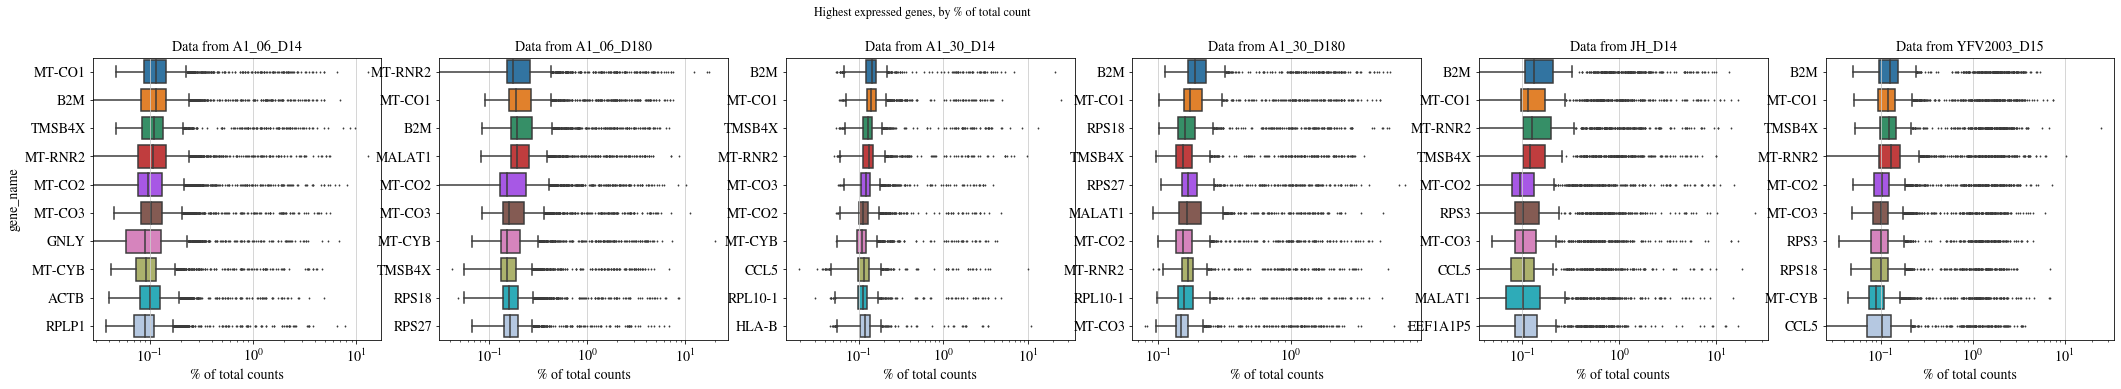

In [77]:
fig,ax = plt.subplots(1,len(donordays), figsize=(len(donordays)*6,5))
for j,ds in enumerate(donordays):
    sc.pl.highest_expr_genes(adata[ds], n_top=10, ax=ax[j], log=True, show=False)
    ax[j].set_title('Data from {}'.format(ds))
    if j > 0:
        ax[j].set_ylabel('')
plt.suptitle('Highest expressed genes, by % of total count', y=1.05)
plt.show()

In [78]:
for ds in donordays:
    adata[ds].var['mt'] = adata[ds].var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata[ds], qc_vars=['mt'], percent_top=None, inplace=True)

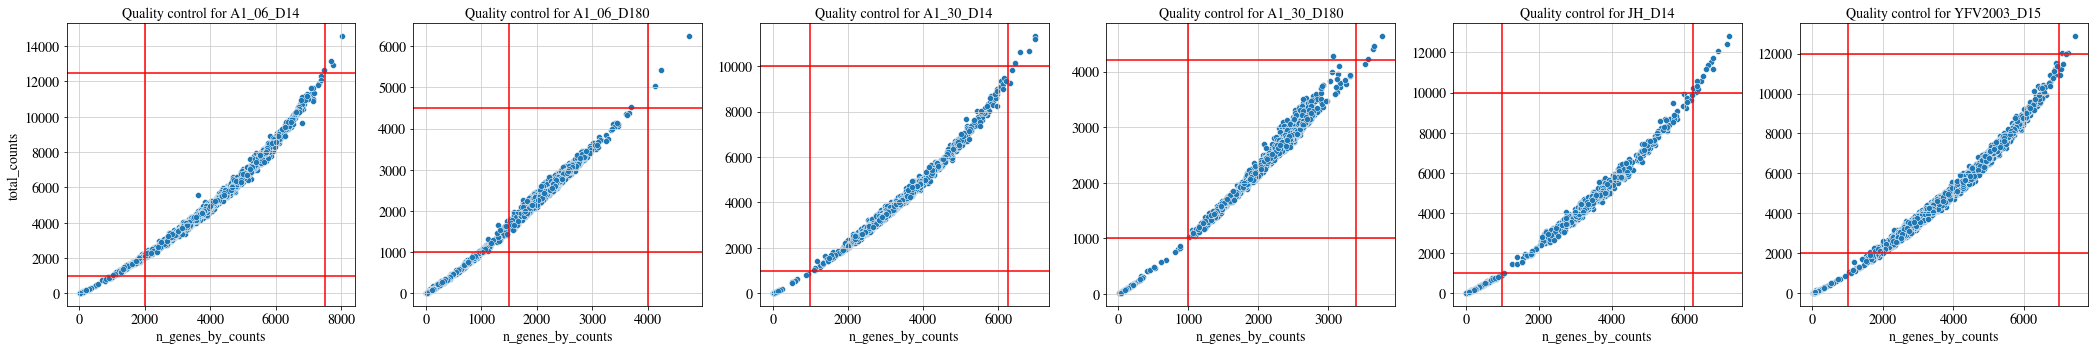

In [79]:
fig,ax = plt.subplots(1,len(donordays), figsize=(len(donordays)*6,5))
# {'A1_06_D14': ,'A1_06_D180': ,'A1_30_D14': ,'A1_30_D180': ,'YFV2003_D14': ,'YFV2003_D15':}
min_counts = {'A1_06_D14': 1000,
              'A1_06_D180': 1000,
              'A1_30_D14': 1000,
              'A1_30_D180': 1000,
              'JH_D14': 1000,
              'YFV2003_D15': 2000}
max_counts = {'A1_06_D14': 12500,
              'A1_06_D180': 4500,
              'A1_30_D14': 10000,
              'A1_30_D180': 4200,
              'JH_D14': 10000,
              'YFV2003_D15': 12000}

min_genes = {'A1_06_D14': 2000,
             'A1_06_D180': 1500, # Shifted after looking at PCA.
             'A1_30_D14': 1000,
             'A1_30_D180': 1000,
             'JH_D14': 1000,
             'YFV2003_D15': 1000}

max_genes = {'A1_06_D14': 7500,
             'A1_06_D180': 4000,
             'A1_30_D14': 6250,
             'A1_30_D180': 3400,
             'JH_D14': 6250,
             'YFV2003_D15': 7000}

for j,ds in enumerate(donordays):
    sns.scatterplot(x='n_genes_by_counts', y='total_counts', 
                    data=adata[ds].obs,  ax=ax[j])
    ax[j].set_title('Quality control for {}'.format(ds))    
    ax[j].axhline(min_counts[ds], color='red')
    ax[j].axhline(max_counts[ds], color='red')
    ax[j].axvline(min_genes[ds], color='red')
    ax[j].axvline(max_genes[ds], color='red')

    if j > 0:
        ax[j].set_ylabel('')
plt.show()

In [80]:
for ds in donordays:
    sc.pp.filter_cells(adata[ds], min_counts=min_counts[ds])
    sc.pp.filter_cells(adata[ds], max_counts=max_counts[ds])
    sc.pp.filter_cells(adata[ds], min_genes=min_genes[ds])
    sc.pp.filter_cells(adata[ds], max_genes=max_genes[ds])

In [81]:
for ds in donordays:
    print(adata[ds])
    hrule()

AnnData object with n_obs × n_vars = 1889 × 11096
    obs: 'Donor', 'Timepoint', 'clone_id', 'DonorDay', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'transcript_length', 'GC_content', 'gene_name', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'log1p'
AnnData object with n_obs × n_vars = 1324 × 8468
    obs: 'Donor', 'Timepoint', 'clone_id', 'DonorDay', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'transcript_length', 'GC_content', 'gene_name', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variance

## Normalizing UMI counts

We normalize the counts so that each cell has a total UMI count of 10000.

In [82]:
for ds in donordays:
    sc.pp.normalize_per_cell(adata[ds], counts_per_cell_after=1e4)

# Saving data

In [83]:
for ds in donordays:
    filename = file_prefix+'_umi_'+ds+file_suffix
    adata[ds].write_loom(filename)
    print('Data written to {}'.format(filename))

Data written to write/anndata_umi_A1_06_D14.loom
Data written to write/anndata_umi_A1_06_D180.loom
Data written to write/anndata_umi_A1_30_D14.loom
Data written to write/anndata_umi_A1_30_D180.loom
Data written to write/anndata_umi_JH_D14.loom
Data written to write/anndata_umi_YFV2003_D15.loom


# Cell cycle scoring

For cell cycle scoring, we follow the [Scanpy notebook here](https://github.com/theislab/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb).  In particular, we use the same list of 97 genes used there, from the Regev lab, based on [Tirosh et al, 2015](https://doi.org/10.1126/science.aad0501). 

In [84]:
cell_cycle_genes = [x.strip() for x in open('regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

In [85]:
for ds in donordays:
    s_genes_tmp = [gene for gene in s_genes if gene in adata[ds].var_names]
    g2m_genes_tmp = [gene for gene in g2m_genes if gene in adata[ds].var_names]
    print('Cell type scoring on {} with {} S-genes and {} G2M-genes'.format(ds, len(s_genes_tmp), len(g2m_genes_tmp)))
    sc.tl.score_genes_cell_cycle(adata[ds], s_genes=s_genes_tmp, g2m_genes=g2m_genes_tmp)

Cell type scoring on A1_06_D14 with 42 S-genes and 52 G2M-genes
Cell type scoring on A1_06_D180 with 15 S-genes and 15 G2M-genes
Cell type scoring on A1_30_D14 with 39 S-genes and 46 G2M-genes
Cell type scoring on A1_30_D180 with 14 S-genes and 16 G2M-genes
Cell type scoring on JH_D14 with 40 S-genes and 44 G2M-genes
Cell type scoring on YFV2003_D15 with 42 S-genes and 52 G2M-genes


We use a basic k-means clustering algorithm to put the cells into two clusters (called cellcycle 0,1,2, maybe corresponding to G2M, S, G1 phases), based on S-score and G2M-score.  But for Day 180 data, we don't see any obvious splits, so we assign each cell the cellcycle label 0.

In [88]:
from sklearn.cluster import KMeans
for ds in donordays:
    if ds[-3:] != '180':
        X = adata[ds].obs[['S_score','G2M_score']]
        kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
        adata[ds].obs['cellcycle'] = kmeans.labels_
    else:
        adata[ds].obs['cellcycle'] = 0

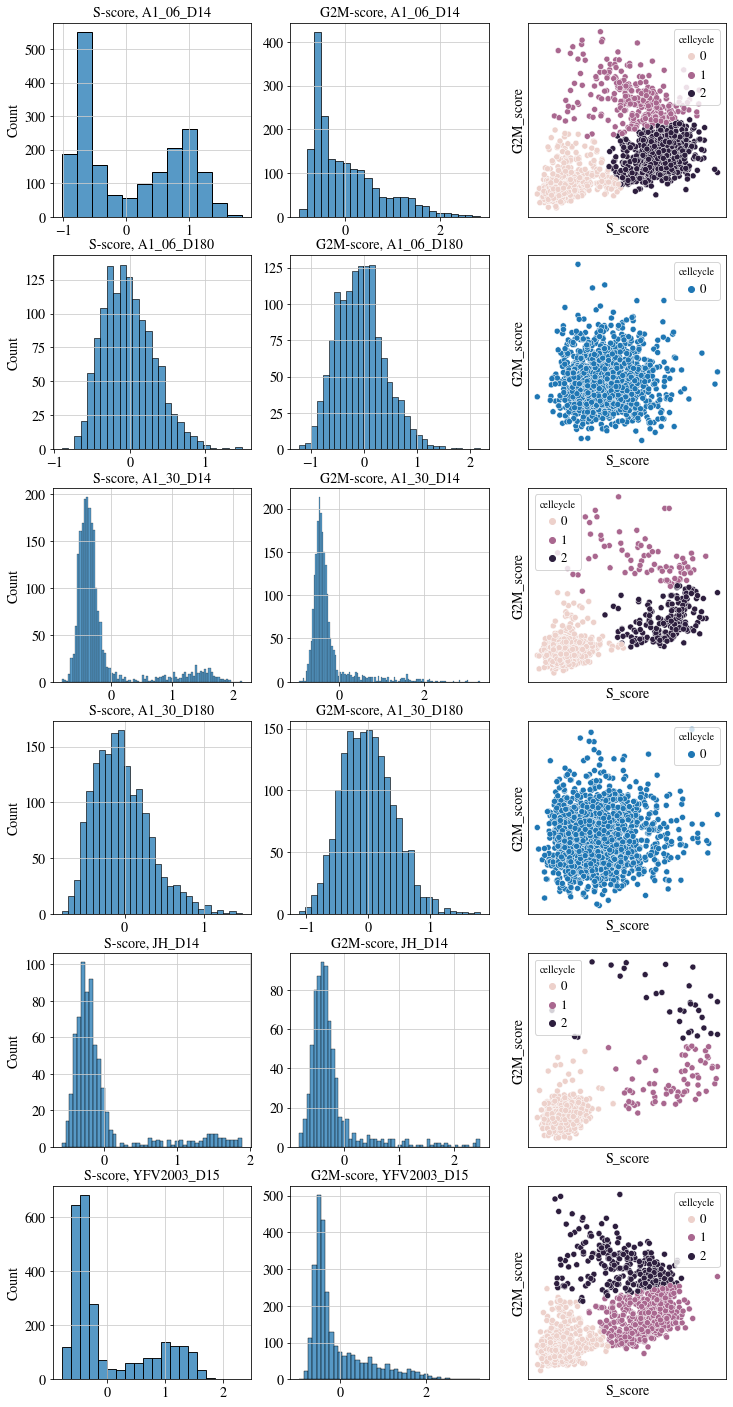

In [89]:
fig,ax = plt.subplots(6,3,figsize=(12,24))
for j,ds in enumerate(donordays):
    sns.histplot(adata[ds].obs.S_score, ax=ax[j,0])
    sns.histplot(adata[ds].obs.G2M_score, ax=ax[j,1])
    ax[j,0].set_title('S-score, {}'.format(ds))
    ax[j,1].set_title('G2M-score, {}'.format(ds))
    ax[j,1].set_ylabel('')
    ax[j,0].set_xlabel('')
    ax[j,1].set_xlabel('')
    sns.scatterplot(x=adata[ds].obs.S_score, y=adata[ds].obs.G2M_score, 
                    hue=adata[ds].obs.cellcycle, ax=ax[j,2])
    ax[j,2].set_xticks([])
    ax[j,2].set_yticks([])
plt.show()

# PCA and Cell type scoring

We create new AnnData objects with z-scores for each gene.

In [90]:
adata_z = {}
for ds in donordays:
    adata_z[ds] = sc.pp.scale(adata[ds], copy=True)

The following fixes an annoying font glitch.  :-/

In [91]:
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

Now we look at PC loadings for each dataset.

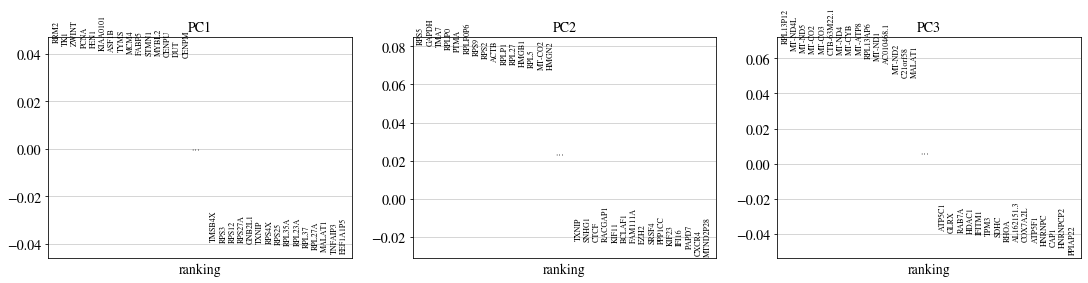

A1_06_D14


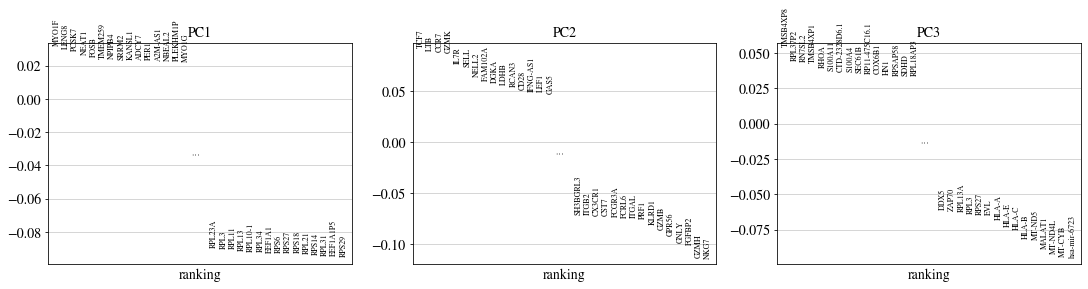

A1_06_D180


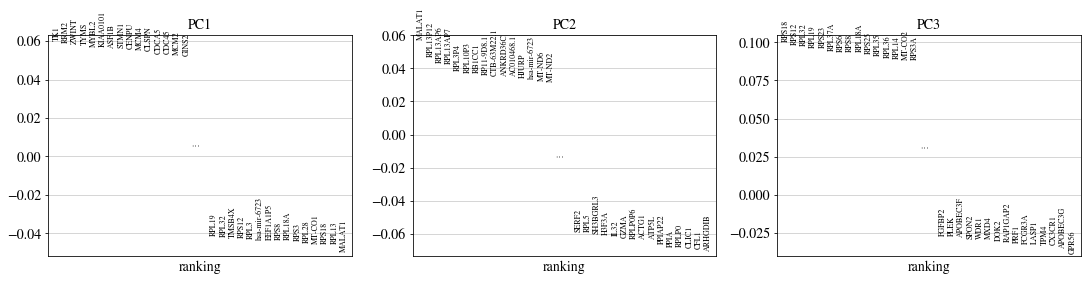

A1_30_D14


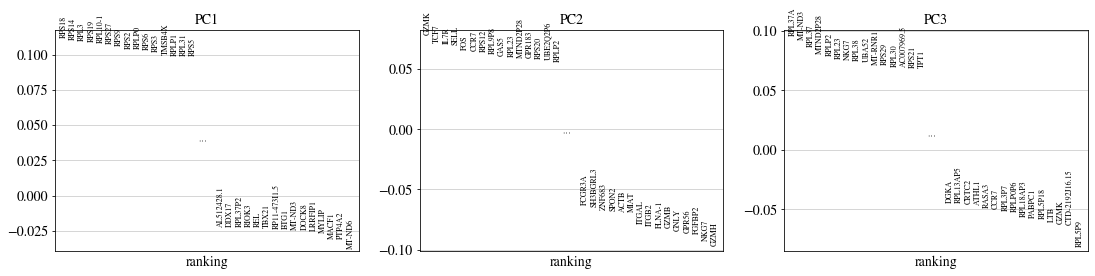

A1_30_D180


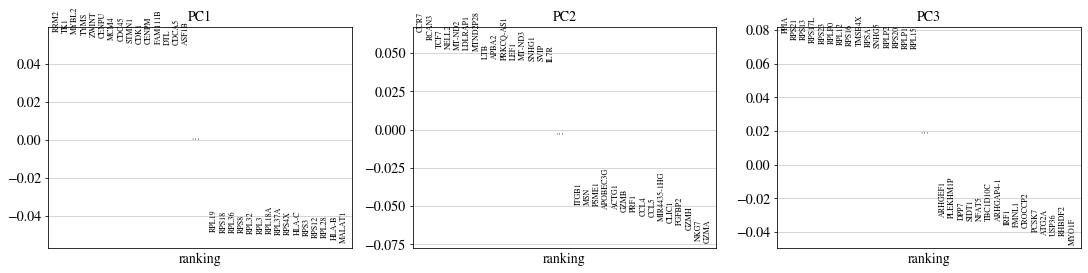

JH_D14


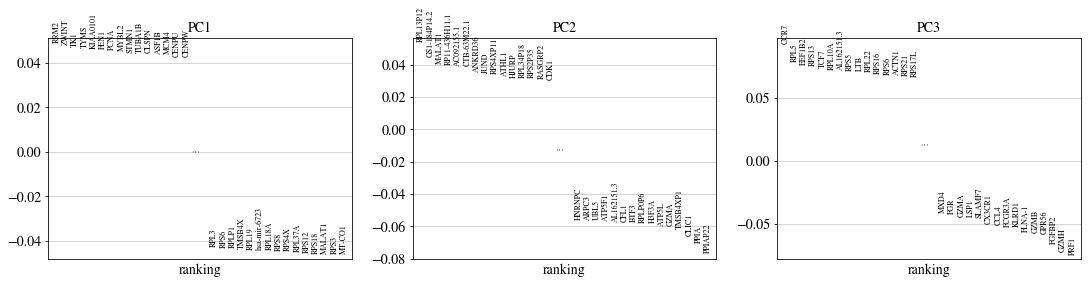

YFV2003_D15


In [92]:
for ds in donordays:
    sc.tl.pca(adata_z[ds], svd_solver='arpack')
    #sc.pl.pca_variance_ratio(adata_z[ds], n_pcs=15, log=True, show=False)
    sc.pl.pca_loadings(adata_z[ds], components=[1,2,3], include_lowest=True)
    print(ds)
    plt.show()
    hrule()

In [93]:
genes_ct = 'CCR7, LTB, NELL2, TCF7, LEF1, GZMB, GZMH, GNLY, CCL5, PRF1, CCL3, CCL4, ZEB2, CX3CR1, IL7R'.split(', ')
print('Some well-known cell-type genes are {}'.format(', '.join(genes_ct)))
print('These occur frequently in PC2s above, in Day 180.')

Some well-known cell-type genes are CCR7, LTB, NELL2, TCF7, LEF1, GZMB, GZMH, GNLY, CCL5, PRF1, CCL3, CCL4, ZEB2, CX3CR1, IL7R
These occur frequently in PC2s above, in Day 180.


Cells without a clone_id label are assigned to "clone 0".  These will be tracked as potential outliers below.

In [94]:
for ds in donordays:
    c0_label = adata_z[ds].obs['clone_id'][0][0] + '0' # Makes A0, B0, C0, as appropriate.
    adata_z[ds].obs['is_clone0'] = (adata_z[ds].obs['clone_id'] == c0_label).astype(np.uint8)
    adata[ds].obs['is_clone0'] = adata_z[ds].obs['is_clone0']
    print('{} cells in Clone 0 in {}'.format(adata_z[ds].obs['is_clone0'].sum(), ds))

77 cells in Clone 0 in A1_06_D14
39 cells in Clone 0 in A1_06_D180
82 cells in Clone 0 in A1_30_D14
83 cells in Clone 0 in A1_30_D180
20 cells in Clone 0 in JH_D14
165 cells in Clone 0 in YFV2003_D15


PCA decomposition for A1_06_D14


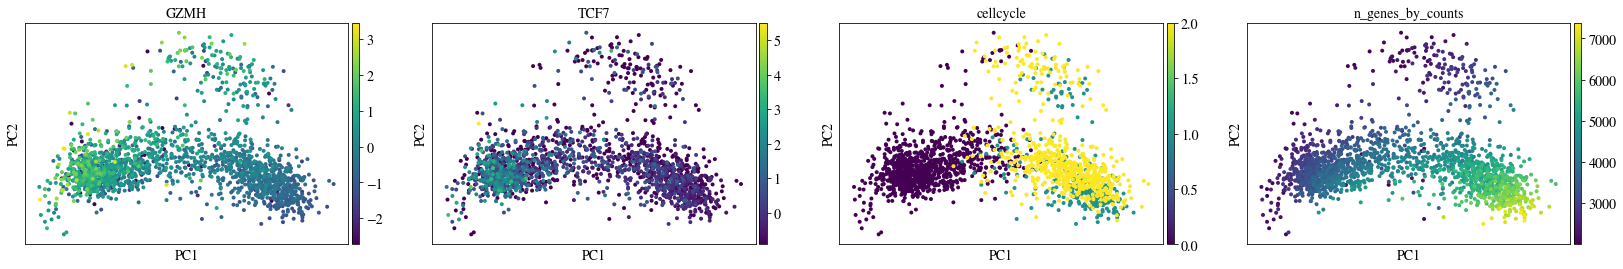

PCA decomposition for A1_06_D180


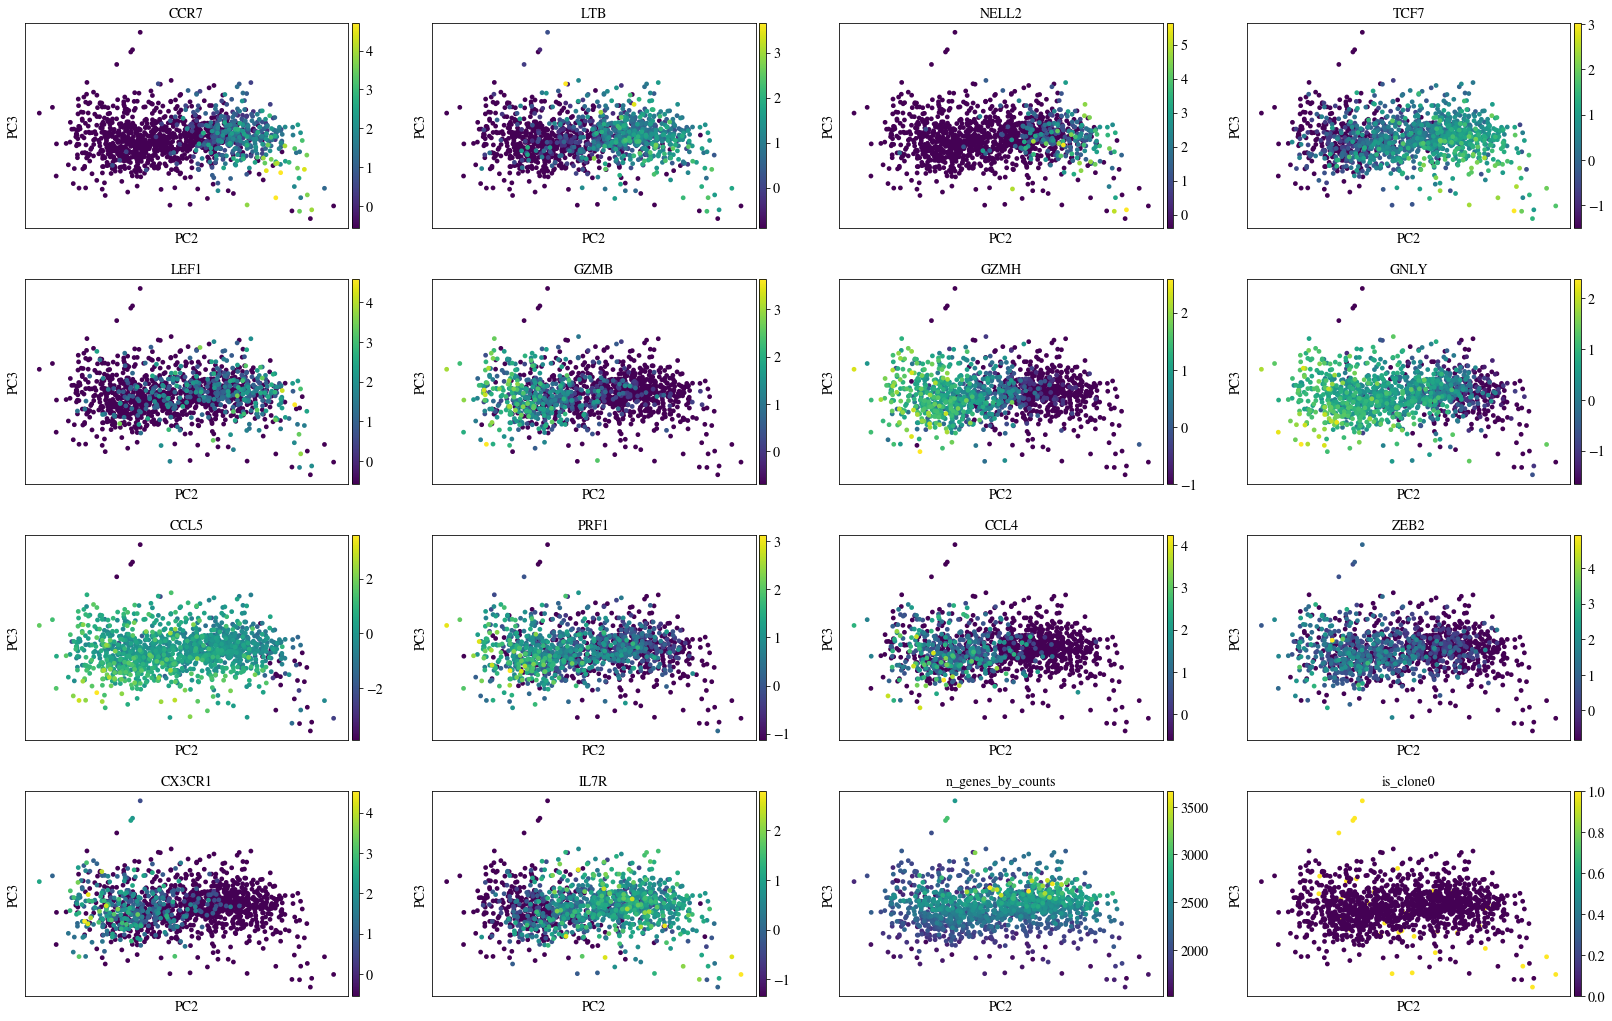

PCA decomposition for A1_30_D14


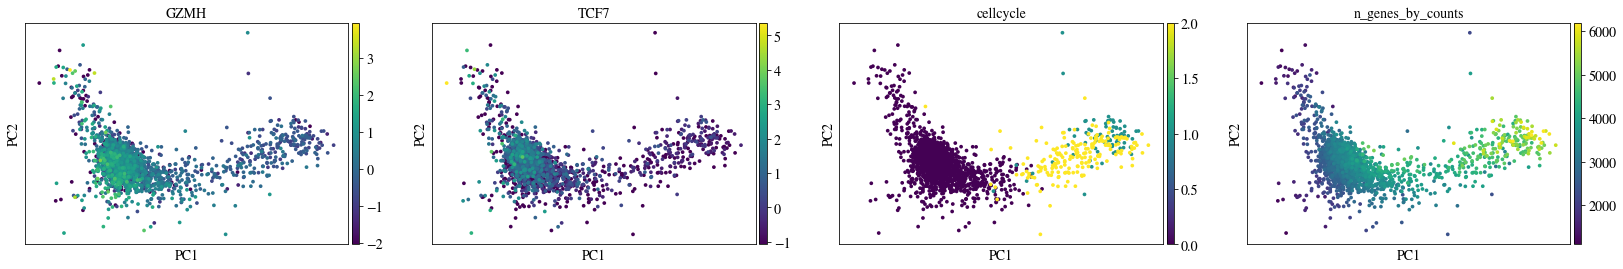

PCA decomposition for A1_30_D180


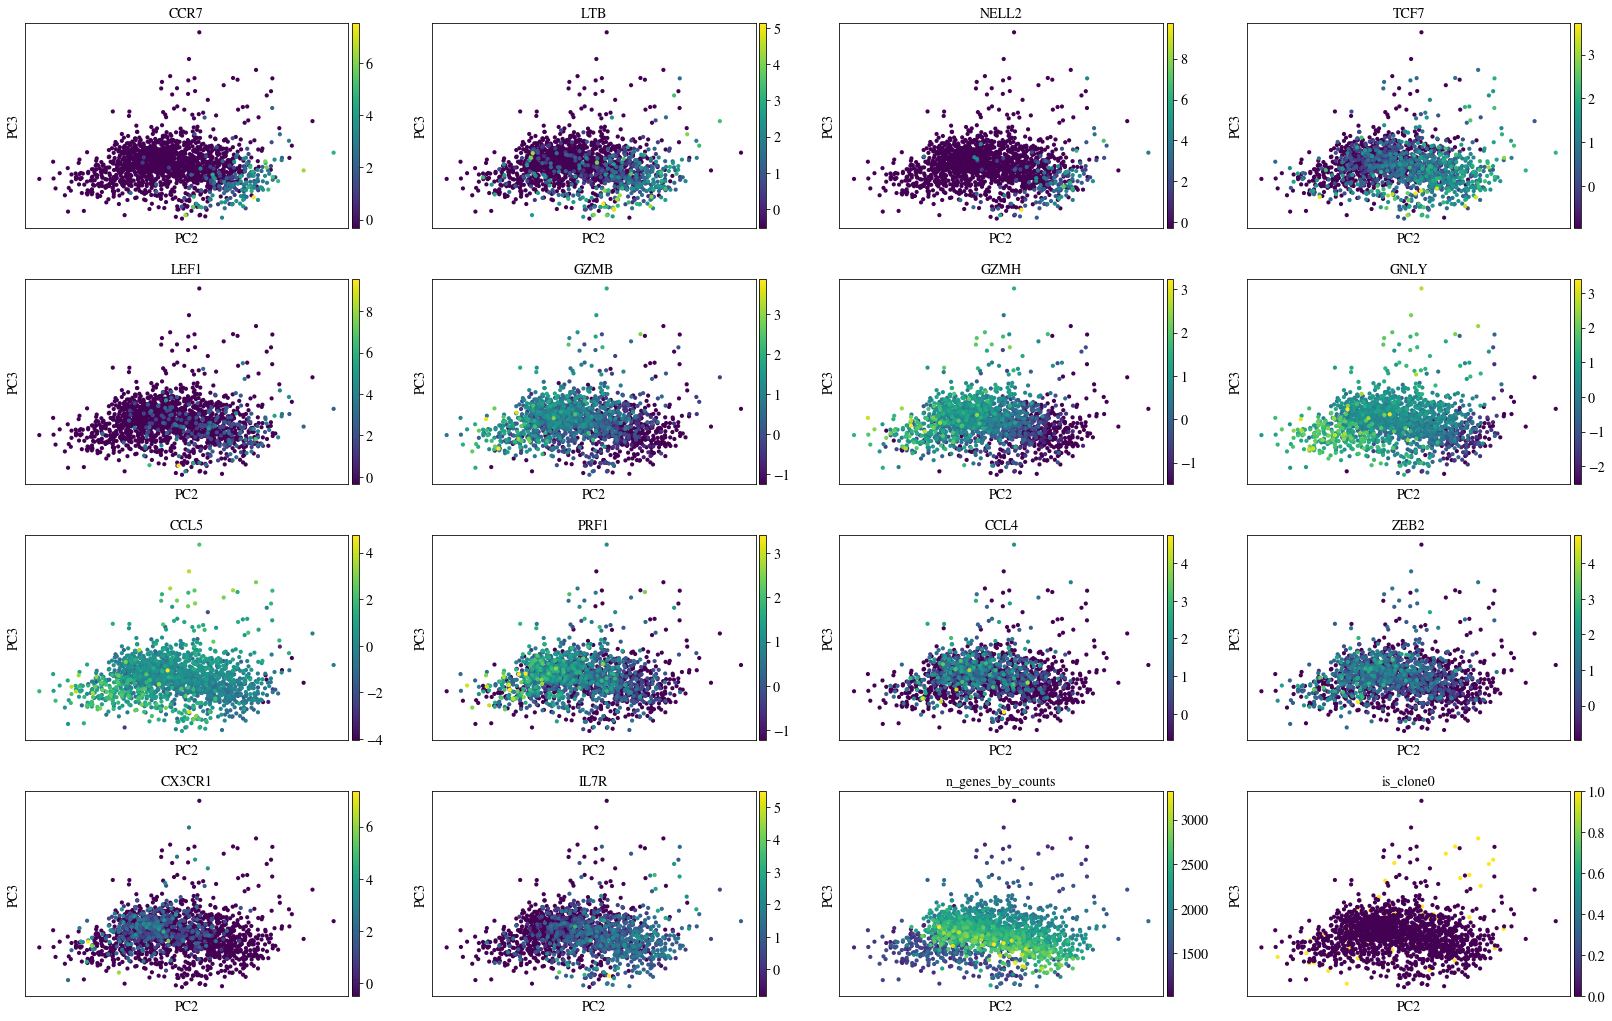

PCA decomposition for JH_D14


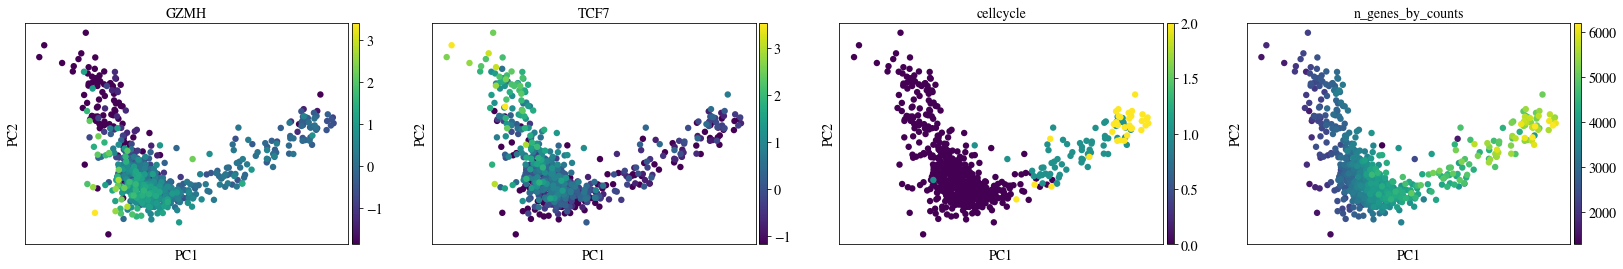

PCA decomposition for YFV2003_D15


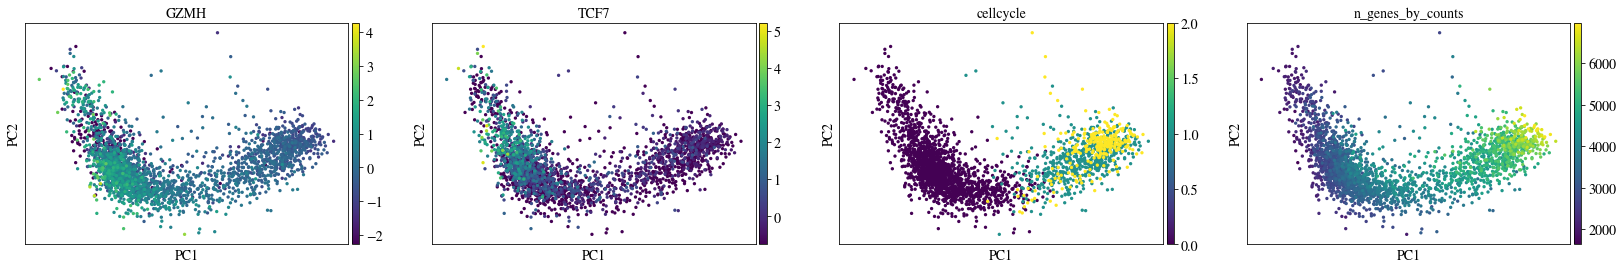

In [102]:
for ds in donordays:
    print('PCA decomposition for {}'.format(ds))
    genelist = [gene for gene in genes_ct if gene in adata_z[ds].var_names]
    if '180' in ds:
        sc.pl.pca(adata_z[ds], color=genelist + ['n_genes_by_counts', 'is_clone0'], components=['2,3'])
    else:
        sc.pl.pca(adata_z[ds], color=['GZMH','TCF7', 'cellcycle','n_genes_by_counts'], components=['1,2'])
    plt.show()
    hrule()

Note that in the day 14-15 data, The PC1/PC2 variation shows clusters based on cell cycle. We should regress out cell cycle effects, or choose cells with common cellcycle label (the same phase, roughly), when dealing with early timepoints.

The genes underlying the celltype score in A1_06_D180 are: NKG7, GZMH, FGFBP2, GNLY, GPR56, GZMB, KLRD1, PRF1, ITGAL, FCRL6, FCGR3A, CST7, CX3CR1, ITGB2, SELL, IL7R, GZMK, CCR7, LTB, TCF7


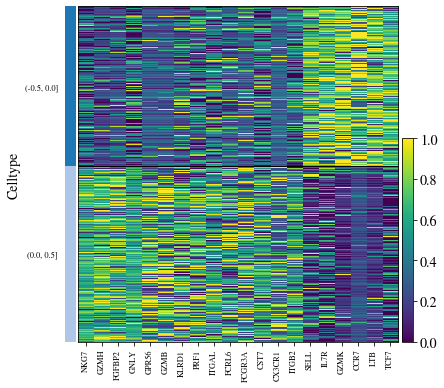

The genes underlying the celltype score in A1_30_D180 are: GZMH, NKG7, FGFBP2, GPR56, GNLY, GZMB, FLNA-1, ITGB2, ITGAL, MIAT, ACTB, SPON2, ZNF683, SH3BGRL3, CCR7, FOS, SELL, IL7R, TCF7, GZMK


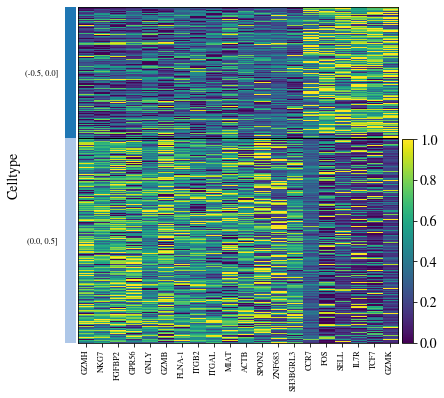

In [96]:
data_180 = [dd for dd in donordays if '180' in dd]

for ds in data_180:
    adata_z[ds].var['PC2_load'] = adata_z[ds].varm['PCs'][:,1]
    
    ct_unnorm = adata_z[ds].obsm['X_pca'][:,1]
    out,bins = pd.cut(ct_unnorm, 2, retbins=True)
    ct_norm = (ct_unnorm - bins[1]) / (bins[2] - bins[0])
    if adata_z[ds].var['PC2_load']['GZMH'] < 0:
        ct_norm = -ct_norm # Make sure positive = EFF consistently.
    adata[ds].obs['Celltype'] = ct_norm
    adata_z[ds].obs['Celltype'] = ct_norm
    avar = adata_z[ds].var
    genelist = list(avar['PC2_load'].abs().nlargest(20).index)
    genelist = list(avar['PC2_load'][genelist].sort_values().index)
    print('The genes underlying the celltype score in {} are: {}'.format(ds, ', '.join(genelist)))
    sc.pl.heatmap(adata_z[ds], var_names=genelist, groupby='Celltype', 
                  standard_scale='obs', num_categories=2, show=None)
    plt.show()

# Saving data

In [97]:
print(donordays)

['A1_06_D14', 'A1_06_D180', 'A1_30_D14', 'A1_30_D180', 'JH_D14', 'YFV2003_D15']


In [98]:
for ds in donordays:
    filename = file_prefix+'_umi_'+ds+file_suffix
    adata[ds].write_loom(filename)
    print('Data written to {}'.format(filename))

Data written to write/anndata_umi_A1_06_D14.loom
Data written to write/anndata_umi_A1_06_D180.loom
Data written to write/anndata_umi_A1_30_D14.loom
Data written to write/anndata_umi_A1_30_D180.loom
Data written to write/anndata_umi_JH_D14.loom
Data written to write/anndata_umi_YFV2003_D15.loom
